# Neural Networks


The goal of this notebook is to forecast the S&P 500 index using Goyal and Welch data and a neural network model.

The code is largely copied and pasted from previous notebooks in Finance 710.

Several updates are made, following the lecture slides:

    - Ensemble model 
    
    - Learning rate and L1 penalty hyperparameter tuning
    
        - (Early stopping already implemented)
        
    - Batch normalization
    
Several different networks are also considered:

    - Approximate Bayes with MC dropout




---



In [15]:
# Import necessary libraries
import pandas as pd
import numpy as np
import warnings

import matplotlib.pyplot as plt

# import additional packages
import random

import ssl
ssl._create_default_https_context = ssl._create_stdlib_context


In [16]:
%matplotlib inline
warnings.filterwarnings('ignore')

np.random.seed(0)
random.seed(0)

### 1. $\quad$ Data

The PredictorData.xls file can be downloaded from Amit Goyal's website:

https://docs.google.com/spreadsheets/d/1bM7vCWd3WOt95Sf9qjLPZjoiafgF_8EG/edit?gid=407859737#gid=407859737$


#### 1.1. $\quad$ Data import


In [17]:
# Retrieve the data
xls_path = 'PredictorData2023.xlsx'

goyal = pd.ExcelFile(xls_path)
df = {sheet_name: goyal.parse(sheet_name) for sheet_name in goyal.sheet_names}

In [18]:
# create date index for monthly data
df['Monthly']['yyyymm'] = pd.to_datetime(df['Monthly']['yyyymm'].astype(str), format='%Y%m')
df['Monthly'].set_index('yyyymm', inplace=True)
df['Monthly'].index = df['Monthly'].index.to_period('M').to_timestamp('M')


# create date index for annual data
df['Annual']['yyyy'] = pd.to_datetime(df['Annual']['yyyy'].astype(str), format='%Y')
df['Annual'].set_index('yyyy', inplace=True)
df['Annual'].index = df['Annual'].index.to_period('Y').to_timestamp('Y')

df = df['Monthly']


df.head()

,Index,D12,E12,b/m,tbl,AAA,BAA,lty,ntis,Rfree,infl,ltr,corpr,svar,csp,CRSP_SPvw,CRSP_SPvwx
yyyymm,,,,,,,,,,,,,,,,,
1871-01-31,4.44,0.26,0.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1871-02-28,4.50,0.26,0.4,NaN,NaN,NaN,NaN,NaN,NaN,0.004967,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1871-03-31,4.61,0.26,0.4,NaN,NaN,NaN,NaN,NaN,NaN,0.004525,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1871-04-30,4.74,0.26,0.4,NaN,NaN,NaN,NaN,NaN,NaN,0.004252,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1871-05-31,4.86,0.26,0.4,NaN,NaN,NaN,NaN,NaN,NaN,0.004643,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 1.2. $\quad$ Data pre-processing



##### Transform the Data



In [19]:
# Dividend Price Ratio (d/p) is the difference between the log of dividends and the log of prices.
df['d/p'] = np.log(df['D12']) - np.log(df['Index'])

# Dividend Yield (d/y) is the difference between the log of dividends and the log of lagged prices.
df['d/y'] = np.log(df['D12'])- np.log(df['Index'].shift(1))

# Earnings Price Ratio (e/p) is the difference between the log of earnings and the log of prices.
df['e/p'] = np.log(df['E12']) - np.log(df['Index'])

# Dividend Payout Ratio (d/e) is the difference between the log of dividends and the log of earnings.
df['d/e'] = np.log(df['D12']) - np.log(df['E12'])

# Term Spread (tms) is the difference between the long term yield on government bonds and the T-bill.
df['tms'] = df['lty'] - df['tbl']

# Default Yield Spread (dfy): is the difference between BAA- and AAA- rated corporate bond yields.
df['dfy'] = df['BAA'] - df['AAA']

# Default Return Spread (dfr): is the difference between the return on long-term corporate bonds and returns on the long-term government bonds.
df['dfr'] = df['corpr'] - df['ltr']

# Calculate Index Price plus Dividends
df['IndexDiv'] = df['Index'] + df['D12']

# Calculate logretdiv (log return with dividends)
df['logretdiv'] = np.log(df['IndexDiv'] / df['Index'].shift(1))

# Calculate logRfree
df['logRfree'] = np.log(df['Rfree'] + 1)

# equity premium, i.e., the total rate of return on the stock market minus the prevailing short-term interest rate.
df['premium'] = df['logretdiv'] - df['logRfree']

df = df.drop(columns=['Index', 'csp', 'D12', 'E12', 'AAA', 'BAA', 'CRSP_SPvwx', 'corpr','Rfree', 'CRSP_SPvw'])

df.head()

,b/m,tbl,lty,ntis,infl,ltr,svar,d/p,d/y,e/p,d/e,tms,dfy,dfr,IndexDiv,logretdiv,logRfree,premium
yyyymm,,,,,,,,,,,,,,,,,,
1871-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.837728,NaN,-2.406945,-0.430783,NaN,NaN,NaN,4.70,NaN,NaN,NaN
1871-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.851151,-2.837728,-2.420368,-0.430783,NaN,NaN,NaN,4.76,0.069593,0.004955,0.064638
1871-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.875302,-2.851151,-2.444519,-0.430783,NaN,NaN,NaN,4.87,0.079017,0.004514,0.074502
1871-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.903111,-2.875302,-2.472328,-0.430783,NaN,NaN,NaN,5.00,0.081210,0.004243,0.076967
1871-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.928112,-2.903111,-2.497329,-0.430783,NaN,NaN,NaN,5.12,0.077117,0.004632,0.072485


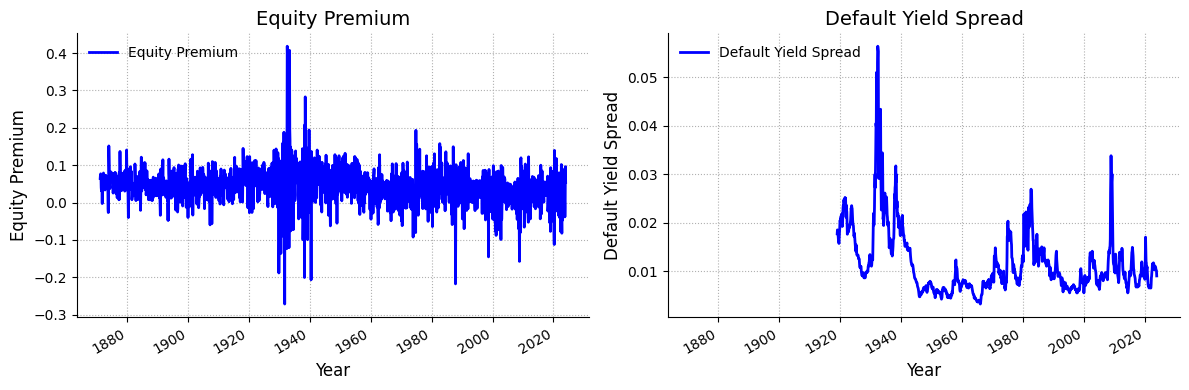

In [20]:
fig, (ax1, ax2) = plt.subplots(
    1, 2,
    figsize=(12, 4),
    sharex=True
)

for ax, col, title in [
    (ax1, 'premium',          'Equity Premium'),
    (ax2, 'dfy',              'Default Yield Spread')
]:
    # thicker, simpler line
    ax.plot(df.index, df[col],
            color='blue', linewidth=2, label=title)

    # titles & labels
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Year',   fontsize=12)
    ax.set_ylabel(title,     fontsize=12)

    # light dotted grid
    ax.grid(True, linestyle=':')

    # legend with no frame
    ax.legend(loc='upper left', frameon=False, fontsize=10)

    # remove top & right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# rotate & align date labels
fig.autofmt_xdate()

fig.tight_layout()
plt.show()


# Display the plot
plt.show()

### 2. $\quad$ Defining the Model

1. Define the target
2. Define the feature set
3. Define a expanding / rolling window forecasting scheme
4. Select and train the model (hyperparameters)
5. Predict OOS


In [21]:
df.ffill(limit=3,inplace=True)

df['target'] = df['premium'].shift(-1)
df.dropna(axis=0, how='any', inplace=True)
y = df['target']

x = df.drop(['target', 'premium'], axis=1)

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.regularizers import l1
from tensorflow.keras.utils import plot_model


def neural_network(input_dim, seed):
    
    tf.random.set_seed(seed)
  
    model = Sequential()
    
    # A single Dense layer (perceptron) with 1 unit and a linear activation function
    model.add(Dense(8, input_shape=(input_dim,), activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(2, activation='relu'))
    model.add(Dense(1, activation='linear'))
    
    # Compile the model
    # The optimizer is set to 'adam', and the loss function to 'mean_squared_error'
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                    loss='mean_squared_error',
                    )

    return model

In [23]:
def neural_network_reg(input_dim, seed, l1_reg, lr):
    
    tf.random.set_seed(seed)
  
    model = Sequential()
    
    # A single Dense layer (perceptron) with 1 unit and a linear activation function
    model.add(Dense(8, input_shape=(input_dim,), activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(BatchNormalization())
    model.add(Dense(4, activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(BatchNormalization())
    model.add(Dense(2, activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='linear'))
    
    # Compile the model
    # The optimizer is set to 'adam', and the loss function to 'mean_squared_error'
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                    loss='mean_squared_error',
                    )

    return model

In [24]:
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

# Create the early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Stop after 5 epochs with no improvement
    restore_best_weights=True  # Restore model weights from the best epoch
)

scaler = StandardScaler()

training_set_size_initial = int(len(x)*(2/3))
validation_set_size = int(training_set_size_initial*(1/3))

y_true, y_hat = [], []

"""
for t in range(0, int(len(x) - training_set_size_initial), 12):
    
    ensemble_predictions = []
    
    # for t in range(training_set_size, len(x),):
    X_train = scaler.fit_transform(x.iloc[:training_set_size_initial + t])
    y_train = y.iloc[:training_set_size_initial + t]
    
    X_test = scaler.transform(x.iloc[training_set_size_initial+t:training_set_size_initial+t+12])
    y_test = y.iloc[training_set_size_initial+t:training_set_size_initial+t+12:]
    
    for _ in range(0,10):
        model = neural_network(X_train.shape[1], _)
        history = model.fit(X_train[:training_set_size_initial + t-validation_set_size], y_train[:training_set_size_initial + t-validation_set_size],
                            epochs=100,
                            batch_size=10000,
                            verbose=0,
                            shuffle=False,
                            callbacks=[early_stopping],
                            validation_data=(X_train[training_set_size_initial + t-validation_set_size:],
                              y_train[training_set_size_initial + t-validation_set_size:])
                            )
    
        ensemble_predictions.append(model.predict(X_test))
    
    y_pred = np.mean(np.array(ensemble_predictions), axis=0)
    
    y_true.extend(y_test)
    y_hat.extend(y_pred)

"""

step = 12

for t in range(0, int(len(x) - training_set_size_initial), step):
    
    ensemble_predictions = []
    
    # for t in range(training_set_size, len(x),):
    X_train = scaler.fit_transform(x.iloc[:training_set_size_initial + t])
    y_train = y.iloc[:training_set_size_initial + t]
    
    X_test = scaler.transform(x.iloc[training_set_size_initial+t:training_set_size_initial+t+step])
    y_test = y.iloc[training_set_size_initial+t:training_set_size_initial+t+step:]

    best_val_loss = float("inf")

    for _ in range(0,10):
        for l1_reg in np.linspace(0.00001, 0.001, 10).tolist():
            for lr in [0.01, 0.001]:
                model = neural_network_reg(X_train.shape[1], _, l1_reg, lr)
                history = model.fit(X_train[:training_set_size_initial + t-validation_set_size], 
                                    y_train[:training_set_size_initial + t-validation_set_size],
                            epochs=100,
                            batch_size=10000,
                            verbose=0,
                            shuffle=False,
                            callbacks=[early_stopping],
                            validation_data=(X_train[training_set_size_initial + t-validation_set_size:],
                              y_train[training_set_size_initial + t-validation_set_size:])
                            )
                val_loss = min(history.history['val_loss'])
                if val_loss < best_val_loss:
                    y_pred_i = model.predict(X_test)
                    best_val_loss = val_loss
        ensemble_predictions.append(y_pred_i)
        
    y_pred = np.mean(np.array(ensemble_predictions), axis=0)
    
    y_true.extend(y_test)
    y_hat.extend(y_pred)
        
# y_pred = np.mean(np.array(ensemble_predictions), axis=0)        


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━

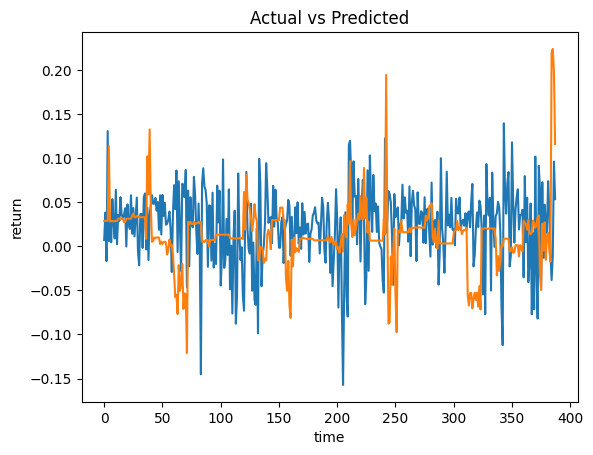

In [25]:
plt.figure()
plt.plot(y_true)
plt.plot(y_hat)
plt.title('Actual vs Predicted')
plt.xlabel('time')
plt.ylabel('return')

plt.show()

In [26]:
# Metrics
from sklearn.metrics import mean_squared_error

def score(y_hat, y, metric):
    """Return metrics of y_hat vs. y

    Args:
        y_hat (np.array): Predicted values
        y (np.array): Actual values
        metric (str): Metric to use

    Returns:
        float: The metric
    """
    if metric == "MSE":
        return np.mean( (y_hat-y)**2)
    elif metric == "R_squared":
        ss_res = np.sum( (y - y_hat)**2 )
        ss_tot = np.sum( (y - np.average(y)) **2)
        return 1 - ss_res/ss_tot
    elif metric == "MAE":
        return np.mean( np.abs(y-y_hat))

In [27]:
#Out-of-sample scores
print("Out-of-sample scores")

y_hat = np.array(y_pred)
y_true = np.array(y_test)

mse_oos = score(y_hat, y_true, "MSE")
r_sq_oos = score(y_hat, y_true, "R_squared")
mae_oos = score(y_hat, y_true, "MAE")

print(f"MSE:{mse_oos}, R^2:{r_sq_oos}, MAE:{mae_oos}")

Out-of-sample scores
MSE:0.03156445636887574, R^2:-44.31801143736049, MAE:0.1640014161374532
